# 오토인코더를 직접 만들어보자

오토인코더란 데이터의 중요한 잠재 표현(Latent representation)을 골라내기 위한 기법이다. 입력 데이터를 그대로 레이블로 활용하므로 비지도 학습의 일종이라 볼 수 있다. 입력 데이터를 최대한 그대로 출력으로 재현해야하므로, 중간의 일어나는 차원축소(인코딩)과 재구성과정(디코딩)을 학습하는 것이 목표이다.

오토인코더 자체는 즉, 대표 특성을 추출한다는 의미가 있으며 다음과 같이 응용할 수 있다:
1. 노이즈 제거
2. 이상치 발견 등.

그러면 먼저 필요한 라이브러리와 예시 데이터셋을 로드해보자

In [1]:
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.losses import MeanSquaredError

In [2]:
from keras.datasets import cifar10

In [3]:
(X_train, _), (X_test, _) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.  # 0~1 사이 값으로 정규화
X_test = X_test.astype('float32') / 255.

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

### 불러온 테스트 이미지 중 첫 10개를 한번 살펴보자

In [4]:
def plot_images(images_arr):
    """show first 10 imgs of an array"""
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr[:10], axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

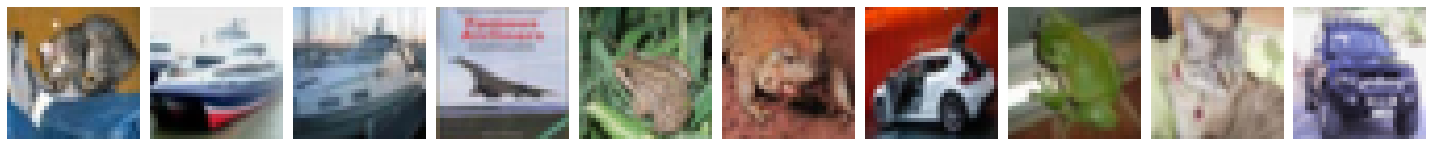

In [5]:
plot_images(X_test)

### 오토인코더 형태의 모델 만들기

In [6]:
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu'), # Latent representation
    Dense(3072, activation='sigmoid'),
    Reshape((32, 32, 3))
])

In [7]:
model.compile(optimizer='adam', loss=MeanSquaredError())

In [8]:
model.fit(X_train, X_train, epochs=5, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/5
1563/1563 [==============================] - 27s 11ms/step - loss: 0.0305 - val_loss: 0.0147
Epoch 2/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0131 - val_loss: 0.0107
Epoch 3/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 4/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 5/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0090 - val_loss: 0.0087


### 이제 모델에 테스트 이미지를 넣어서 나오는 이미지를 보자

In [9]:
decoded_imgs = model(X_test).numpy()

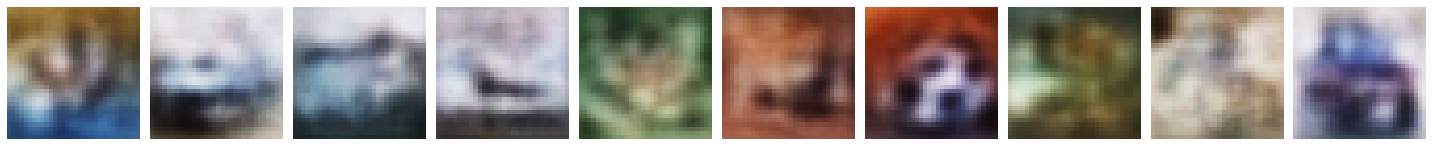

In [10]:
plot_images(decoded_imgs)

# 그러나 이렇게 만든 오토인코더는 현재 응용이 어렵다.
오리지널 데이터를 넣어서 오리지널 데이터가 나오는게 무슨 의미가 있겠는가?
### 그보다는 인코더 부분, 디코더 부분으로 모델을 나누는 것이 추후 활용도가 높아진다
왜냐하면 이렇게 학습된 인코더 부분은 **본래의 데이터를 잘 대표하는 특성만 남기는 차원축소의 효과**가 있기 때문이고, 반대로 디코더 부분은 **일부 특성으로 원본을 재구성하는 기능**을 갖추었기 때문이다.

모델 두개를 따로 만들 수도 있지만, 클래스 방식으로 만들어보도록 한다.

In [12]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super().__init__() # 상속받은 부모 Model 클래스 초기화
        
        self.latent_dim = latent_dim # 축소할 목표 차원
        
        # 인코더
        self.encoder = Sequential([
            Flatten(input_shape=(32, 32, 3)),
            Dense(latent_dim, activation='relu')
        ])
        
        # 디코더
        self.decoder = Sequential([
            Dense(3072, activation='sigmoid'),
            Reshape((32, 32, 3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
autoencoder = Autoencoder(latent_dim=512)

In [13]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [14]:
autoencoder.fit(X_train, X_train, epochs=5, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/5
1563/1563 [==============================] - 20s 10ms/step - loss: 0.0307 - val_loss: 0.0139
Epoch 2/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0132 - val_loss: 0.0107
Epoch 3/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 5/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0094 - val_loss: 0.0095


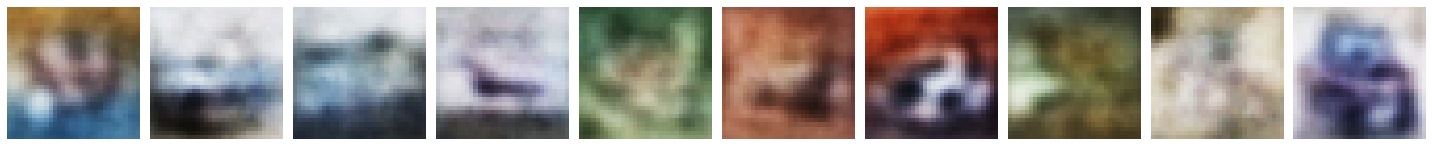

In [15]:
decoded_imgs = autoencoder(X_test).numpy()
plot_images(decoded_imgs)